<a href="https://colab.research.google.com/github/markdevine/ET5003_SEM1_2021-2/blob/main/Etivity_1_MarkDevine_19187289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [93]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [94]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "19187289" #@param {type:"string"}
Student_full_name = "Mark Devine" #@param {type:"string"}
#@markdown ---

In [95]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

## Introduction and Method




The purpose of this etivity is to extend the code from the given template to manage any arbitary number of classes, whereby implementing a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier. First import all necessary libraries utilised within the code. Then load the MNIST dataset from google Drive. There is a training dataset of 60000 digit images and a test dataset of 10000 digit images. X_train and y_train contain the training set, while X_test and y_test contain the test data. The images are encoded as Numpy arrays and their corresponding labels ranging from 0 to 9. These MNIST images of 28×28 pixels are represented as an array of numbers whose values range from [0, 255] of type uint8. Before implementing the classifiers the input values should be scaled to values of type float32 within the interval [0, 1].  (https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487) I have a general look at the dataset and it confirms the description of the MNIST dataset. I randomly select 3 unique digits to use for classification purposes and then down sample the instances for each of the 3 digits randomly. Then reshape the inputs and labels vertically and horizontally using the Numpy vstack and hstack functions. I display the first 100 digit instances and then 100 random digit instances. Next split the dataset into training and validation sets whereby the validation set is 20% of the original dataset using sklearn.model_selection.train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Then utilise the sklearn.linear_model.LogisticRegression class with the ‘lbfgs’ solvers, an initial regularization value of 100 and the multi_class, ‘multinomial’ whereby the loss minimised is the multinomial loss fit across the entire probability distribution (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). This classification scores an accuracy level of 0.916. Now create a text report showing the main classification metrics using sklearn.metrics.classification_report (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) and the confusion matrix using sklearn.metrics.confusion_matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to evaluate the accuracy of the classification. Prior to fitting a multinomial logistic regression on a subset of the dataset utilise the sklearn.preprocessing.LabelBinarizer class to transform the classes into counts (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html). Next incorporate PyMC3, an open-source Probabilistic Programming framework which allows allows flexible specification of Bayesian statistical models in code, supporting definition and fitiing of the model and then the posterior analysis(https://docs.pymc.io/notebooks/getting_started.html).

## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

### References
Getting started with PyMC3 — PyMC3 3.10.0 documentation [WWW Document], n.d. URL https://docs.pymc.io/notebooks/getting_started.html (accessed 9.18.21).
MNIST classification using multinomial logistic + L1 — scikit-learn 1.1.dev0 documentation [WWW Document], n.d. URL https://scikit-learn.org/dev/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html (accessed 9.18.21).
sklearn.linear_model.LogisticRegression — scikit-learn 0.24.2 documentation [WWW Document], n.d. URL https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html (accessed 9.18.21).
sklearn.metrics.classification_report — scikit-learn 0.24.2 documentation [WWW Document], n.d. URL https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html (accessed 9.18.21).
sklearn.metrics.confusion_matrix — scikit-learn 0.24.2 documentation [WWW Document], n.d. URL https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html (accessed 9.18.21).
sklearn.model_selection.train_test_split — scikit-learn 0.24.2 documentation [WWW Document], n.d. URL https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html (accessed 9.18.21).
sklearn.preprocessing.LabelBinarizer — scikit-learn 0.24.2 documentation [WWW Document], n.d. URL https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html (accessed 9.18.21).
TORRES.AI, J., 2021. Deep Learning for Beginners [WWW Document]. Medium. URL https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487 (accessed 9.18.21).


## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [96]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [97]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray
from matplotlib import pyplot
from sklearn.metrics import classification_report, confusion_matrix

In [98]:
# Setting a seed:
np.random.seed(157)

## Dataset

### Loading the MNIST dataset

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# Path, copy the path from your Drive
path = '/content/drive/MyDrive/Colab Notebooks/Data/mnist/'

# MNIST Data
train_data = path + 'mnist_train.csv'
test_data = path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train_original = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train_original.shape)

# test data
df_test = pd.read_csv(test_data)
X_test_original = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test_original.shape)


(60000, 784)
(10000, 784)


In [101]:
# Normalizing the inputs by making it float between 0.0 and 1.0:
X_train_normal = X_train_original/255
X_test_normal = X_test_original/255

# Printing the new input range of values:
minv = np.min(X_train_normal)
maxv = np.max(X_train_normal)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [102]:
# Get the number of examples
n_train, n_test =  len(X_train_normal), len(X_test_normal)

# get the shape of a digit image
image_shape = X_train_normal.shape[1]

# unique classes/labels in the training dataset.
print("y_train", y_train)
# Let's see what classes exist in my training set
distinct_classes = set(y_train)
print("distinct_classes", distinct_classes)
# Get the number of classes 
n_classes = len(distinct_classes)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

y_train [5 0 4 ... 5 6 8]
distinct_classes {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

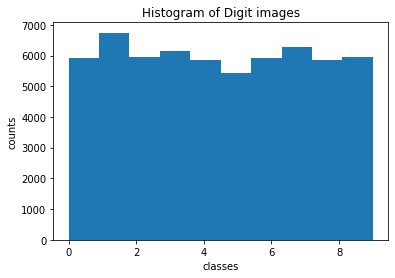

In [103]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [104]:
# We select the number of Classes we want:
n_selected_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_selected_classes:
    
    # Randomly draw a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
print('classes', classes)

# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
print('classes', classes)

classes [8, 3, 2]
classes [2, 3, 8]


In [105]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 1000

# Loop to randomly sample the instances for each digit:
inputs, labels = [], []
for r in classes:
    imgs = X_train_normal[np.where(y_train==r)[0],:]
    # print("imgs.shape", imgs.shape[0])
    # randonly shuffle and then select instance classes from the set
    _input = imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:]
    # print("_input", _input)
    inputs.append(_input)
    _labels = np.ones(inst_class)*r
    # print("_labels",_labels)
    labels.append(_labels)

    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

imgs.shape 5958
_input [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
_labels [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 

New Classes Distribution

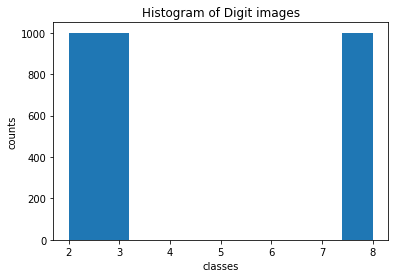

In [106]:
# new histogram
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

In [107]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    print('instances length', len(instances))
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

instances length 100


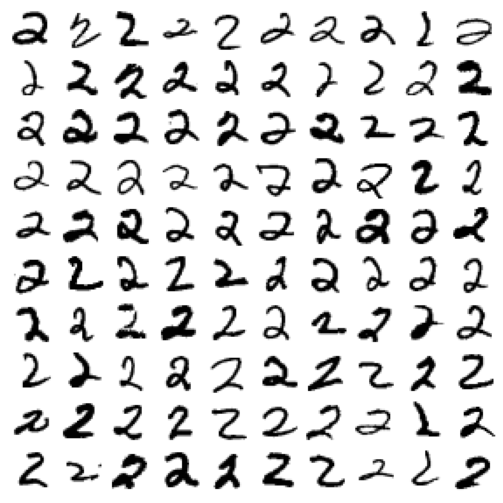

In [108]:
# plot the first 100 images just to see what they look like
plt.figure(figsize=(9,9))
example_images = X_train[0:100]
plot_digits(example_images, images_per_row=10)
plt.show()

instances length 100


Text(0.5, 1.0, 'Original')

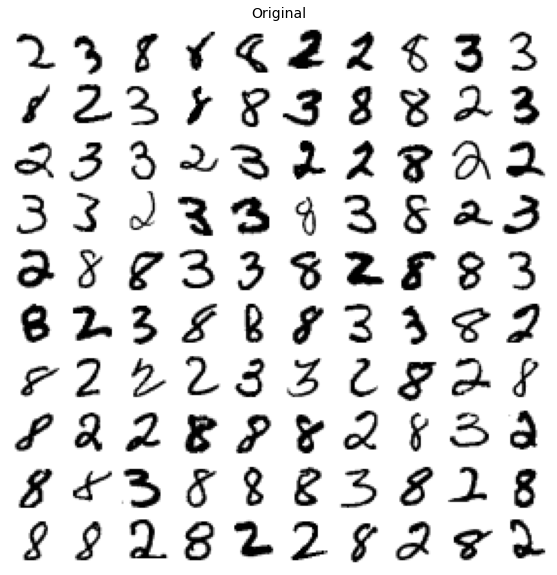

In [109]:

# Show a few instances from each Digit:
plt.figure(figsize=(10,10))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = [random.randint(1,X_train.shape[0]) for i in range(100)]

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=10)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [110]:
### Split the dataset into training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [111]:
# print shape of your validation and training set

# Shape of the validation and training set
validation_set_shape = X_val.shape
training_set_shape = X_train.shape

print("Training Set Shape =", training_set_shape)
print("Validation Set Shape =", validation_set_shape)

Training Set Shape = (2400, 784)
Validation Set Shape = (600, 784)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

Accuracy = 0.9166666666666666

instances length 1


Text(0.5, 1.0, 'Hardest image to classify')

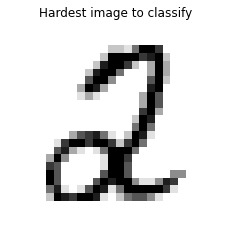

In [112]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
print("Accuracy =", accuracy_score(y_pred_log, y_val))
print()

# plot image hardest to recognise
# thanks to Carlos for suggesting this nice addition
plot_digits(X_train[np.array([np.argmin(prob_classmax)]),:],images_per_row=9)
plt.title("Hardest image to classify", fontsize=12)

In [113]:
# print the confusion matrix and the classification report
# thanks to Nigel for reminding me of this which we used in an earlier module

target_names = []
for d in classes:
  target_names.append("digit " + str(d))

print("Confusion Matrix")
print()
print(confusion_matrix(y_val, y_pred_log))
print()
print("Classification Report")
print()
print(classification_report(y_val, y_pred_log, target_names = target_names))

Confusion Matrix

[[217   7  13]
 [  5 173   9]
 [  8   8 160]]

Classification Report

              precision    recall  f1-score   support

     digit 2       0.94      0.92      0.93       237
     digit 3       0.92      0.93      0.92       187
     digit 8       0.88      0.91      0.89       176

    accuracy                           0.92       600
   macro avg       0.91      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



### Probabilistic Multinomial Logistic Regression:

In [114]:
np.sort(prob_classmax)

array([0.44523974, 0.51224655, 0.53353904, 0.53579148, 0.55403053,
       0.5692081 , 0.57081557, 0.57556346, 0.58256289, 0.5861849 ,
       0.5894621 , 0.60301879, 0.60333725, 0.61249759, 0.63282582,
       0.64980552, 0.69697662, 0.73111271, 0.73706292, 0.74085164,
       0.75208599, 0.75881299, 0.76441153, 0.76700723, 0.810418  ,
       0.8232559 , 0.83602068, 0.83861403, 0.84433473, 0.85239634,
       0.86040147, 0.87363254, 0.88300958, 0.88814817, 0.8926318 ,
       0.8994223 , 0.90058004, 0.90210448, 0.91041736, 0.92443638,
       0.93035894, 0.9320086 , 0.93395629, 0.93502401, 0.93702324,
       0.94040067, 0.94289341, 0.94403337, 0.94569412, 0.94663273,
       0.96024021, 0.96193553, 0.96288992, 0.96297918, 0.96584134,
       0.96700541, 0.96936714, 0.96947669, 0.97108564, 0.97135773,
       0.97215867, 0.97338015, 0.97355573, 0.97382376, 0.97412106,
       0.97460303, 0.97621271, 0.97644032, 0.97903963, 0.98067027,
       0.98120341, 0.9815139 , 0.98200645, 0.98229104, 0.98266

In [115]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log!=y_val]

array([0.97412106, 0.98811205, 0.83602068, 0.93502401, 1.        ,
       0.99750216, 0.96936714, 0.57556346, 0.76700723, 0.99998867,
       0.97338015, 0.93702324, 0.73706292, 0.73111271, 0.99997049,
       0.99841494, 0.99999857, 0.9867846 , 0.99997503, 0.99312003,
       0.99999119, 0.61249759, 0.99938749, 0.98229104, 0.64980552,
       0.9984352 , 0.99984726, 0.88300958, 0.84433473, 0.99993867,
       0.99999985, 0.5894621 , 0.99207099, 1.        , 0.5692081 ,
       0.99998605, 0.69697662, 0.99997964, 0.99994115, 0.75208599,
       0.99434082, 0.99999066, 0.94403337, 0.87363254, 0.75881299,
       0.99521553, 0.97903963, 0.55403053, 0.94040067, 0.99462911])

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [116]:
import sklearn.preprocessing
## We use LabelBinarizer to transform classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
print(y_train)
print(y_train.reshape(-1,1))
print(X_train.shape[1])
nf = X_train.shape[1]
# number of classes
number_of_classes = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, number_of_classes-1).astype(floatX)
init_a = np.random.randn(number_of_classes-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, number_of_classes-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(number_of_classes-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension number_of_classes
    # so that softmax returns a vector of dimension number_of_classes
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

[3. 3. 8. ... 8. 2. 3.]
[[3.]
 [3.]
 [8.]
 ...
 [8.]
 [2.]
 [3.]]
784


In [117]:
y_2_bin

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]])

In [118]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 11,398


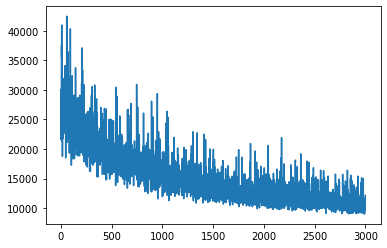

In [119]:
plt.plot(approx.hist)

In [120]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 3.0
classes: [2, 3, 8]
estimated prob= [0.01351118 0.9864853  0.00000352]


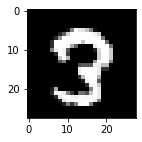

In [121]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [122]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [123]:
print(y_pred_Bayesian)

[0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 2, 2, 0, 1, 1, 2, 0, 1, 0, 1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0, 1, 1, 0, 2, 0, 2, 0, 1, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 2, 2, 0, 2, 1, 0, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 2, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 2, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 2, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 1, 0, 0, 1, 0, 2, 2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 0, 

In [124]:
# recall the classes we are using
print(classes)

[2, 3, 8]


In [125]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([2, 3, 3, 8, 8, 8, 8, 3, 3, 3])

In [126]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.8216666666666667


In [127]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [128]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.55457649, 0.49507575],
       [1.        , 0.9893123 , 0.11469767],
       [1.        , 0.58064208, 0.49243161],
       [2.        , 0.91264554, 0.28134597],
       [2.        , 0.96658832, 0.17950549],
       [2.        , 0.95785074, 0.18794207],
       [2.        , 0.68747193, 0.45969797],
       [1.        , 0.42021977, 0.49459299],
       [1.        , 0.98090688, 0.14      ],
       [1.        , 0.53187338, 0.49781746]])

In [129]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.48775955, 0.5       ],
       [0.        , 0.50579083, 0.49998889],
       [1.        , 0.49127726, 0.49998889],
       [0.        , 0.50242625, 0.49998889],
       [2.        , 0.49901211, 0.49998889],
       [1.        , 0.47493644, 0.49998889],
       [1.        , 0.49764461, 0.49995555],
       [1.        , 0.50294494, 0.49995555],
       [0.        , 0.47927951, 0.49995555],
       [0.        , 0.52086918, 0.49995555]])

In [130]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([0.97412106, 0.98811205, 0.83602068, 0.93502401, 1.        ,
       0.99750216, 0.96936714, 0.57556346, 0.76700723, 0.99998867,
       0.97338015, 0.93702324, 0.73706292, 0.73111271, 0.99997049,
       0.99841494, 0.99999857, 0.9867846 , 0.99997503, 0.99312003,
       0.99999119, 0.61249759, 0.99938749, 0.98229104, 0.64980552,
       0.9984352 , 0.99984726, 0.88300958, 0.84433473, 0.99993867,
       0.99999985, 0.5894621 , 0.99207099, 1.        , 0.5692081 ,
       0.99998605, 0.69697662, 0.99997964, 0.99994115, 0.75208599,
       0.99434082, 0.99999066, 0.94403337, 0.87363254, 0.75881299,
       0.99521553, 0.97903963, 0.55403053, 0.94040067, 0.99462911])

In [131]:
y_predB[y_pred_log != y_val,:]

array([[1.        , 0.58064208, 0.49243161],
       [2.        , 0.98663318, 0.09949874],
       [2.        , 0.93545669, 0.23120458],
       [1.        , 0.50391432, 0.49959984],
       [1.        , 0.73574151, 0.4404417 ],
       [0.        , 0.49423133, 0.49972215],
       [2.        , 0.48949495, 0.49982219],
       [1.        , 0.89224599, 0.29089899],
       [1.        , 0.61794433, 0.4869862 ],
       [0.        , 0.42471373, 0.49300665],
       [2.        , 0.78513088, 0.40247843],
       [2.        , 0.52561245, 0.49972215],
       [0.        , 0.78524754, 0.39491209],
       [1.        , 0.61073626, 0.48368952],
       [0.        , 0.42842841, 0.49507575],
       [0.        , 0.73214119, 0.43679387],
       [2.        , 0.95157359, 0.18794207],
       [2.        , 0.68044853, 0.4567883 ],
       [2.        , 0.49901211, 0.49998889],
       [0.        , 0.65651426, 0.47140452],
       [0.        , 0.92963616, 0.24356154],
       [0.        , 0.8139818 , 0.38138636],
       [2.

In [132]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.98
Accuracy in difficult instances = 0.84


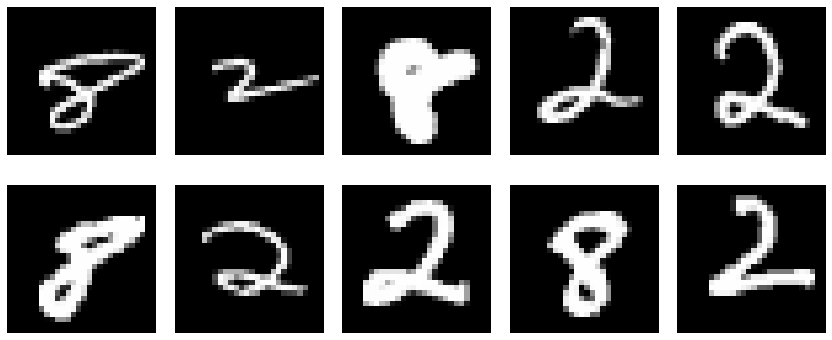

In [133]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

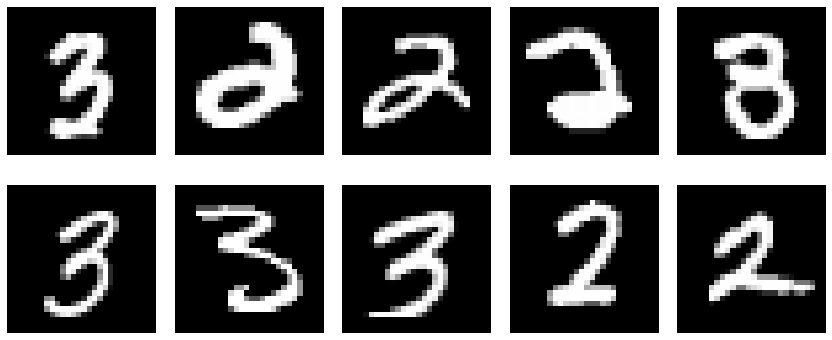

In [134]:

# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")

## Now compute the accuracy of the general-recipe logistic regression only on the remaining easy instances

In [135]:
# model
model_logi_retrained = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train[easy], y_train[easy])

# Classification
y_pred_logi_retrained = model_logi_retrained.predict(X_val)
y_pred_logi_prob_retrained = model_logi_retrained.predict_proba(X_val)

prob_classmax_retrained = np.max(y_pred_logi_prob_retrained,axis=1)

# Computing the Accuracy
# Original
print(f"Original Model Accuracy {accuracy_score(y_pred_log, y_val):.4f}\nNumber of misclassifications {len(prob_classmax[y_pred_log!=y_val])}")
# Retrained
print(f"Retrained Model Accuracy: {accuracy_score(y_pred_logi_retrained, y_val):.4f}\nNumber of misclassifications {len(prob_classmax_retrained[y_pred_logi_retrained!=y_val])}")

Original Model Accuracy 0.9167
Number of misclassifications 50
Retrained Model Accuracy: 0.9033
Number of misclassifications 58


## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.